<a href="https://colab.research.google.com/github/animesh182/Final-Year-Project/blob/main/ganfull_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [ ]:
import os
import math
import numpy as np
import torch
import skimage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow import keras
import pathlib
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import PReLU
from IPython import display
import random
from matplotlib import pyplot
import PIL
from tensorflow.keras.applications import VGG19



SETTING GLOBAL VARIABLES

In [ ]:
train_ds_lr = keras.Input(shape=(24,24,1))
train_ds_hr = keras.Input(shape=(96,96,1))
crop_size = (96, 96)
batch_size = 64
upscale_factor = 4
input_size = 24 

DEFINING DISCRIMINATOR MODEL

In [ ]:
def get_discriminator_model(channels=1,kernel_size=3):
    input = (96,96,channels)
    model = Sequential()
    filter=[64,64,128,128,256,256,512,512]
    for id, size in enumerate(filter):
      if(id==0):
        model.add(layers.Conv2D(size,kernel_size,strides=id%2+1,padding="same",input_shape=input))
      model.add(layers.Conv2D(size,kernel_size = 3, strides=id % 2 + 1, padding="same"))
      model.add(BatchNormalization())
      model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    return model




                                                                      DEFINING GENERATOR MODEL

In [ ]:

def get_generator_model(channels=1):           # Main Method that returns gen model
  input = keras.Input(shape=(24,24,channels))
  model = layers.Conv2D(64,kernel_size=9,strides=1,padding="same")(input)
  model = PReLU()(model)
  NewModel= get_generator_residual(model)
  FinalModel = get_generator_shuffler(NewModel)
  FinalModel = layers.Conv2D(1,kernel_size=9,strides=1,padding="same")(FinalModel)
  FinalModel = layers.Rescaling(scale=127.5, offset=127.5)(FinalModel)
  return keras.Model(input,FinalModel)

  
def get_generator_residual(model, kernel_size=3, filters=64, stride=1):
  residual = np.arange(15)
  NewModel = layers.Conv2D(filters,kernel_size, stride, padding="same")(model)
  NewModel = BatchNormalization()(NewModel)
  NewModel = PReLU()(NewModel)
  NewModel = layers.Conv2D(filters,kernel_size,stride, padding="same")(NewModel)
  NewModel = BatchNormalization()(NewModel)
  xSkip = layers.Add()([model, NewModel])
  for x in residual:
    if x!=14:
      NewModel = layers.Conv2D(filters,kernel_size, stride, padding="same")(xSkip)
      NewModel = BatchNormalization()(NewModel)
      NewModel = PReLU()(NewModel)
      NewModel = layers.Conv2D(filters,kernel_size,stride, padding="same")(NewModel)
      NewModel = BatchNormalization()(NewModel)
      xSkip = layers.Add()([xSkip, NewModel])
    else:
      NewModel = layers.Conv2D(filters,kernel_size, stride, padding="same")(xSkip)
      NewModel = BatchNormalization()(NewModel)
      NewModel = layers.Add()([model,NewModel])
  return NewModel

def get_generator_shuffler(model, kernel_size=3,filters=256,stride=1,upscale_factor=2):
  iterator = np.arange(2)
  for  x in iterator:
    model = layers.Conv2D(filters,kernel_size,stride,padding="same")(model)
    model = tf.nn.depth_to_space(model,upscale_factor)
    z=layers.PReLU()(model)
  return z




DEFINING ACTUAL GAN MODEL

In [ ]:
def get_gan_model(gen_model, dis_model,vgg,lr_dataset,hr_dataset):
  gen_img= gen_model(lr_dataset)
  dis_model.trainable = False
  conv = tf.image.grayscale_to_rgb(gen_img) #not sure
  # gen_img=get_original_rgb_img(gen_img)
  gen_features = vgg(conv)
  validity = dis_model(gen_img)
  return keras.Model([lr_dataset,hr_dataset],[validity,gen_features])

DEFINING VGG19 MODEL

In [ ]:
def build_vgg(input_size=(96,96,3)):
    vgg = VGG19(input_shape=input_size, weights="imagenet",include_top=False)
    outputs = [vgg.layers[9].output]
    return keras.Model(vgg.input, outputs)

                        DATA SOURCE FOR MODEL

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
root_dir = "/gdrive/MyDrive/dataset"
root_dir = pathlib.Path(root_dir)


                    SPLITTING DATA INTO VALIDATION AND TRAINING

In [ ]:

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=crop_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=crop_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)
# dataset = os.path.join(root_dir, "finished/train/dataraw")
# train_path = os.path.join(dataset, "hires")
# train_img_paths = sorted(
#     [
#         os.path.join(test_path, fname)
#         for fname in os.listdir(train_path)
#         if fname.endswith(".jpg")
#     ]
# )
testset = os.path.join(root_dir,"finished")
test_path = os.path.join(testset, "test" )

test_img_paths=sorted(
    [
     os.path.join(test_path,fname)
     for fname in os.listdir(test_path)
     if fname.endswith(".jpg")
    ]
)


Found 5160 files belonging to 1 classes.
Using 4128 files for training.
Found 5160 files belonging to 1 classes.
Using 1032 files for validation.


                              PREPPING DATASET FOR MODEL INPUT AND COMPARISON



In [ ]:
def normalize(images):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images

# The map function applies the normalize function to each element in the train
# and test datasets
train_ds_vgg =  train_ds.map(normalize)
print(train_ds)

valid_ds  =  valid_ds.map(normalize)

<BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>


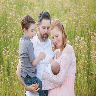

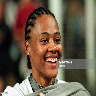

In [ ]:
for batch in train_ds.take(1):
  i = 0
  for img in batch:
      display.display(array_to_img(img))
      i+=1
      if i == 2:
        break

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 24, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None))>


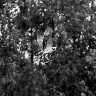

In [ ]:
# Makes Image B/W
def process_input(input, input_size):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")

def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

def process_original(input):
  return input






train_ds = train_ds.map(
    lambda x: (process_input(x,input_size=24),process_target(x),process_original(x))
)
print(train_ds)
for batch in train_ds.take(1):
  i = 0
  for img in batch:
      display.display(array_to_img(img[0]))
      i+=1
      if i == 2:
        break

In [ ]:
def get_lowres_image(img,upscale_factor):
  return img.resize((img.size[0] // upscale_factor, img.size[1] // upscale_factor), PIL.Image.BICUBIC,)


def print_rgb_img(gray_img, cb,cr,width,height):
    pred_img_y = np.clip(gray_img, 0, 255)
    pred_img_y=np.squeeze(gray_img)
    pred_img_y = pred_img_y.reshape((np.shape(pred_img_y)[0], np.shape(pred_img_y)[1]))
    pred_img_y = PIL.Image.fromarray(np.uint8(pred_img_y), mode="L")
    pred_img_cb = cb.resize(pred_img_y.size, PIL.Image.BICUBIC)
    pred_img_cr = cr.resize(pred_img_y.size, PIL.Image.BICUBIC)
    pred_img = PIL.Image.merge("YCbCr", (pred_img_y, pred_img_cb, pred_img_cr)).convert("RGB")
    pred_img.resize((width,height))
    org = img_to_array(pred_img)
    save_plot(org)


                                                REAL(SUPER RESOLUTIONED) SAMPLES FROM GENERATOR

In [ ]:
def real_sample_generator(dataset, samples):
  y = np.asarray(dataset[1], dtype='object')
  rd = np.random.randint(0,int(y.shape[0]),int(samples))
  selected_real = y[rd].astype('float32')
  numbering = np.ones((samples,1))
  print(selected_real.shape)
  return selected_real, numbering


        FAKE SAMPLES FOR DISCRIMINATOR AKA REAL SAMPLES FROM GENERATOR




In [ ]:
def fake_sample_generator(gen_model, images, samples):
  y = np.asarray(images[0], dtype='object')
  rd = np.random.randint(0,int(y.shape[0]),int(samples))
  selected_real = y[rd].astype('float32')
  fake_samples = gen_model.predict(selected_real)
  numbering= np.zeros((samples,1))
  return fake_samples, numbering
    

Image Generator

In [ ]:
def hq_image_generator(gen_model,img_path,samples,counter,test_phase=True):
 print("Generating Images")
 fake_samples = 0
 for  image in img_path[counter:counter+samples]:
    img = load_img(image)

    w = img.size[0]
    h = img.size[1]
    img = img.resize((96,96))
    test_1 = img_to_array(img)
    final = np.array([test_1])
    save_plot(final)
    image = get_lowres_image(img,upscale_factor)
    test = img_to_array(image)
    final = np.array([test])
    save_plot(final)
    ycbcr = image.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    input_arr = np.expand_dims(y, axis=0)
    save_plot(input_arr)
    final_samples = gen_model.predict(input_arr)
    pred_img_y = final_samples[0]
    pred_img_y = np.expand_dims(pred_img_y,0)
    if(test_phase==False):
      print_rgb_img(pred_img_y,cb,cr,w,h)
    
    # pred_img_y*= 255 
    # pred_img_y = pred_img_y.clip(0, 255)
    # print(pred_img_y.shape)
    # pred_img_y = pred_img_y.reshape((np.shape(pred_img_y)[0], np.shape(pred_img_y)[1]))
    # print(pred_img_y.shape)
    # pred_img_y = PIL.Image.fromarray(np.uint8(pred_img_y), mode="L")
    # pred_img_cb = cb.resize(pred_img_y.size, PIL.Image.BICUBIC)
    # pred_img_cr = cr.resize(pred_img_y.size, PIL.Image.BICUBIC)
    # pred_img = PIL.Image.merge("YCbCr", (pred_img_y, pred_img_cb, pred_img_cr)).convert("RGB")
    # pred_img.resize((w,h))
    numbering = np.zeros((samples,1))
    return pred_img_y, numbering

TESTING GENERATED SAMPLES

In [ ]:
def save_plot(examples):
 examples= examples.astype("float32")/255
 fig, ax = pyplot.subplots()
 examples = examples.squeeze()
 im = ax.imshow(examples[::-1], origin="lower",cmap="gray")
 pyplot.show()
 pyplot.close()

EVALUATING THE DISCRIMINATOR AND SAVING MODEL




In [ ]:
def model_evaluation(gen_model,dis_model, dataset,epoch, sample_batch =1):
        x_real,y_real = real_sample_generator(dataset, sample_batch)
        print("finished")
        _,real_accuracy = dis_model.evaluate(x_real,y_real,verbose=0)
        print("finished accuracy calculation")
        x_fake,y_fake = hq_image_generator(gen_model,test_img_paths,sample_batch,0)
        print("finished2")
        _,fake_accuracy = dis_model.evaluate(x_fake,y_fake,verbose=0)
        print('>%d real= %.0f%% fake = %.0f%%'%(epoch,real_accuracy*100,fake_accuracy*100))
        %cd /gdrive/MyDrive/dataset
        %mkdir -p saved_model
        %cd saved_model
        filename = 'generator_model_%03d.h5' % ( epoch + 1)
        gen_model.save(filename)
        save_plot(x_fake)


TRAINING THE MODEL

In [ ]:
def train(gen_model,dis_model, gan_model, dataset,epochs=100,batch=64):
    half_batch = int(batch/2)
    for m in range(epochs):
      for id, data in enumerate(dataset):
        X_real, y_real = real_sample_generator(data, half_batch)
        X_fake, y_fake = fake_sample_generator(gen_model, data, half_batch)
        X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
        dis_model.trainable=True
        print(X.shape)
        d_loss, _ = dis_model.train_on_batch(X, y)
        dis_model.trainable=False
        if(id==64):
          y_gan = np.ones((half_batch, 1))
        else:
          y_gan = np.ones((batch,1))
        vgg_predict=[]
        print(data[2].shape)
        predict = vgg.predict(data[2])
        g_loss,_,_ = gan_model.train_on_batch([data[0],data[1]],[y_gan,predict])
        print('>epoch: %d, batch: %d/%d, discriminator loss: d=%.3f, overall model loss: g=%.3f' % (m, id, batch, d_loss, g_loss))
      if (m+1) % 10 == 0:
        model_evaluation(gen_model, dis_model, data,m )

RUNNING THE MODEL

In [ ]:
dis_model=get_discriminator_model()
DOptimizer = keras.optimizers.Adam(learning_rate=0.00001,beta_1=0.9)
dis_model.compile(loss="binary_crossentropy",optimizer=DOptimizer,metrics=['accuracy'])
dis_model.summary()

vgg = build_vgg()
vgg.trainable = False

gen_model=get_generator_model()
gen_model.summary()

gan_model=get_gan_model(gen_model,dis_model,vgg,train_ds_lr,train_ds_hr)
GOptimizer=keras.optimizers.Adam(learning_rate=0.00001,beta_1=0.9)
gan_model.compile(loss=["binary_crossentropy","mse"],optimizer=GOptimizer,loss_weights=[1e-3,1])

train(gen_model,dis_model, gan_model, train_ds)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

KeyboardInterrupt: ignored

In [ ]:
gen_model=tf.keras.models.load_model('/gdrive/MyDrive/dataset/saved_model/generator_model_100.h5')
testing_img = '/gdrive/MyDrive/dataset/finished/test/dt_val_3.jpg'
fake_input_arr = np.array([testing_img])
x_img,y_img = hq_image_generator(gen_model,fake_input_arr,1,0,False)
save_plot(x_img)
orgy_image = load_img(testing_img)
org = img_to_array(orgy_image)
save_plot(org)



